In [ ]:
import sys
import os

sys.path.append(os.path.abspath('..'))

import yaml
import pandas as pd
from sklearn.model_selection import train_test_split

from src.data.prepare_data import prepare_data
from src.models.utils import train_splits
from src.models.model_selection import ClassifierThreshold
from src.models.model import Classifier
from src.visuals.pr_roc_curve import plot_roc_pr_curves
from src.models.evaluation import Evaluation

In [2]:
# read config
with open('../'+'config.yml', 'r') as file:
    config=yaml.load(file, Loader= yaml.SafeLoader)
del file

In [3]:
# load and prepare data
df = pd.read_csv('../'+config['data_loader']['path'])
df = prepare_data(df=df)
display(df.head())

# check class distributions
df['label'].value_counts(normalize=True)

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


label
0    0.998273
1    0.001727
Name: proportion, dtype: float64

In [4]:
# split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:,:-1], df['label']
    , test_size=config['train_test_split']['test_size']
    , random_state=123
    , shuffle=True
    , stratify=df['label']
    )

# check class distributions
print(
    y_train.value_counts(normalize=True)
    , y_test.value_counts(normalize=True)
    )

label
0    0.998274
1    0.001726
Name: proportion, dtype: float64 label
0    0.998245
1    0.001755
Name: proportion, dtype: float64


In [5]:
# split train sets into multiple sets and check class distributions
train = train_splits(X_train, y_train, config['train_test_split'])
[train[i].iloc[:,-1].value_counts(normalize=True) for i in train.keys()]

[label
 0    0.99827
 1    0.00173
 Name: proportion, dtype: float64,
 label
 0    0.998278
 1    0.001722
 Name: proportion, dtype: float64]

Ideal threshold value: 0.4846333582800898


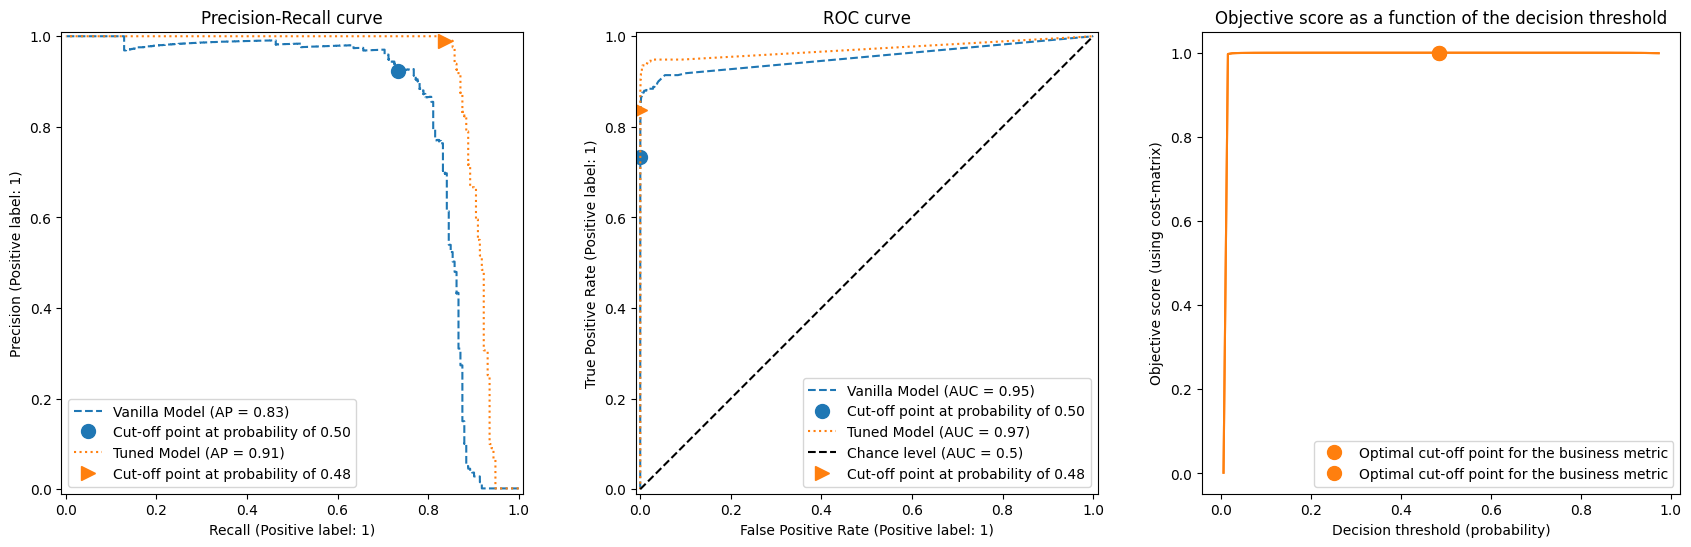

In [ ]:
# fit algorithm
clf = Classifier(
    algorithm='XGBClassifier'
    , **{'n_estimators': 10, 'max_depth': 20}
    )

clf.fit(X=train[1].iloc[:, :-1], y=train[1].iloc[:,-1])

# tune classification threshold
tuned_clf = ClassifierThreshold(config=config['optimization'])
tuned_clf.fit(clf=clf, X=train[2].iloc[:,:-1], y=train[2].iloc[:,-1])

threshold = tuned_clf.best_threshold
print(f'Ideal threshold value: {threshold}')

plot_roc_pr_curves(clf.model, tuned_clf.model, X_train=train[2].iloc[:,:-1], y_train=train[2].iloc[:,-1])

In [ ]:
# fit algorithm on whole training set
clf = Classifier(
    algorithm='XGBClassifier'
    , **{'n_estimators': 10, 'max_depth': 20}
    )
clf.fit(X=X_train, y=y_train)

# test set evaluation
for i in [0.5, threshold]:
    eval = Evaluation(clf=clf, threshold=i)
    display(
        eval.fit(
            #metric=config['optimization']['scoring_metric'],
            train=(X_train, y_train),
            test=(X_test, y_test)
            )
            )

,accuracy,precision,recall,f1_score
dataset,,,,
train,0.99975,1.0,0.85439,0.92148
test,0.99937,0.9,0.72000,0.80000


,accuracy,precision,recall,f1_score
dataset,,,,
train,0.99975,0.99751,0.85867,0.9229
test,0.99937,0.90000,0.72000,0.8000
